In [1]:
from math import ceil
from qiskit import QuantumCircuit, Aer, transpile
from qiskit.quantum_info.operators import Operator
from qiskit.circuit.library import QFT
import numpy as np
import math
from fractions import Fraction
from math import gcd
from sympy.logic.boolalg import ANFform


# Grover search algorithm

In [2]:
def prepareGroverBlackBox(qubits: int, markedNumber: int):
    blackBox = QuantumCircuit(qubits, name="Grover's Black Box")
    if 2**(qubits-1)-1 < markedNumber:
        raise Exception('markedNumber is too Big')
    matrix = np.zeros((2**qubits, 2**qubits))
    for i in range(2**(qubits-1)):
        binaryNumber = bin(i)[2:].rjust(qubits-1, '0')
        if i == markedNumber:
            matrix[int(binaryNumber+'0', 2)][int(binaryNumber+'1', 2)] = 1
            matrix[int(binaryNumber+'1', 2)][int(binaryNumber+'0', 2)] = 1
        else:
            matrix[int(binaryNumber+'0', 2)][int(binaryNumber+'0', 2)] = 1
            matrix[int(binaryNumber+'1', 2)][int(binaryNumber+'1', 2)] = 1
    blackBox.unitary(matrix, range(qubits))
    return Operator(blackBox).to_instruction()

def inversionAboutMean(qubits: int):
    matrix = 2*np.full((2**qubits, 2**qubits), 1/(2**qubits)) - np.eye(2**qubits)
    inversionAboutMean = QuantumCircuit(qubits, name="Inversion About Mean")
    inversionAboutMean.unitary(matrix, range(qubits))
    return Operator(inversionAboutMean).to_instruction()
    
def grover(qubits: int, markedNumber:int):
    qc = QuantumCircuit(qubits+1, qubits)
    qc.x(qubits)
    qc.barrier()
    qc.h(range(qubits+1))
    numIterations = ceil(np.sqrt(2**qubits))
    print (numIterations)
    for _ in range(numIterations):
        qc.append(prepareGroverBlackBox(qubits+1, markedNumber), range(qubits,-1,-1))
        qc.append(inversionAboutMean(qubits), range(qubits-1,-1,-1))
    qc.measure(range(qubits), range(qubits))
    return qc

4
{'0101': 25, '0000': 23, '1010': 29, '1110': 33, '0010': 26, '1011': 29, '1111': 26, '1101': 25, '1000': 30, '0001': 24, '0011': 30, '0111': 34, '0110': 28, '1100': 25, '0100': 605, '1001': 32}
0010


/Users/pijus/.pyenv/versions/3.11.4/lib/python3.11/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


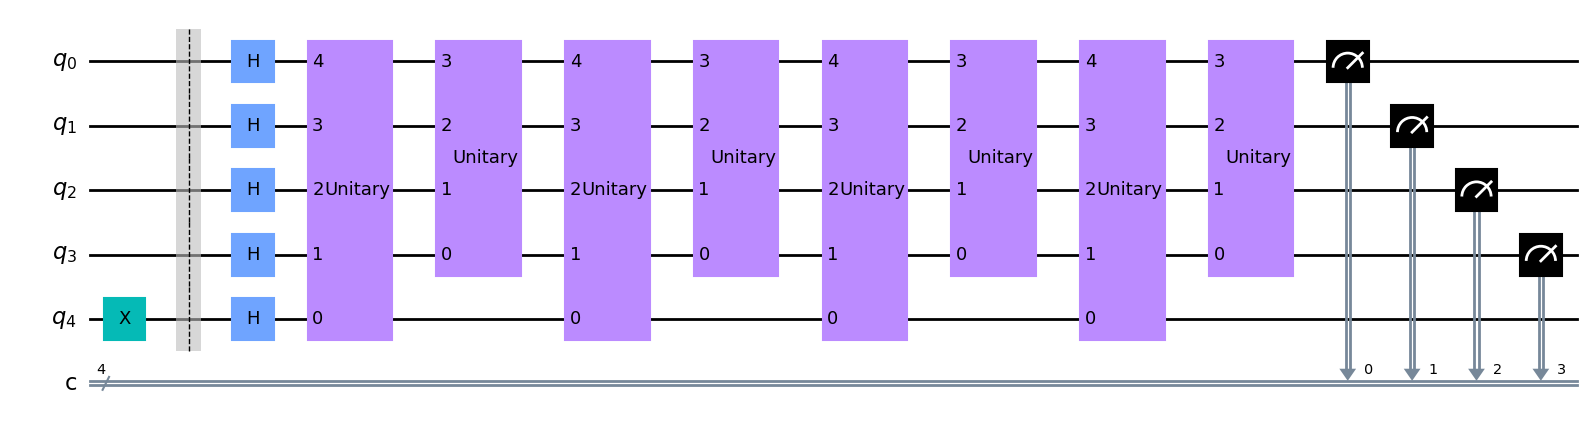

In [3]:
leng = 4
number = 2

qc = grover(leng, number)

backend = Aer.get_backend('qasm_simulator')
job = backend.run(qc, shots=1024)
result = job.result()
print(result.get_counts())
counts = dict(result.get_counts())
max = 0
for key, value in counts.items():
    if value > max:
        max = value
        maxKey = key

print (maxKey[::-1])
qc.draw('mpl')

# Shors factoring algorithm

In [4]:
def aMod15(a,x,size):
    qc = QuantumCircuit(size)
    for _ in range(x):
        if a in [2,13]:
            qc.swap(0,1)
            qc.swap(1,2)
            qc.swap(2,3)
        if a in [7,8]:
            qc.swap(2,3)
            qc.swap(1,2)
            qc.swap(0,1)
        if a == 11:
            qc.swap(1,3)
            qc.swap(0,2)
        if a in [7,11,13]:
            qc.x(range(size))
    unitary = qc.to_gate()
    return unitary.control(1)

def modExp(n,m,a):
    qc = QuantumCircuit(n+m,name='modExp')
    for i in range(n):
        qc.append(aMod15(a,2**i,m),[i]+list(range(n,m+n)))
    return Operator(qc).to_instruction()

def shor(n:int, m:int, a:int=2):
    qc = QuantumCircuit(n+m, n)
    
    qc.h(range(n))
    qc.x(n+m-1)
    qc.barrier()
    qc.append(modExp(n,m,a), range(n+m))
    qc.barrier()
    qc.append(Operator(QFT(n).inverse()).to_instruction(), range(n))

    qc.measure(range(n), range(n))
    return qc

def processMeasurement(measurement,n):
    binaryString = ''.join(map(str, measurement))
    measuredInt = int(binaryString,2)
    phase = measuredInt/(2**n)
    f = Fraction.from_float(phase).limit_denominator(n)
    _,r = f.numerator, f.denominator
    print ("corresponding phase",phase," r ",r)
    return r, phase

In [5]:
N = 15 # number to factor

coprime = False
while coprime == False:
    a = np.random.randint(2, N)
    if math.gcd(a,N) == 1 and a in [2,7,8,11,13]:
        coprime = True

factorFound = False
attempts = 0
print ("trying with a=",a,"and N=",N)
while factorFound == False:
    attempts += 1
    qc = shor(n,m,a)
    backend = Aer.get_backend('qasm_simulator')
    job = backend.run(qc, shots=1)
    result = job.result()
    counts = list(result.get_counts().keys())
    print ("attempts",attempts,"counts",counts)
    r, phase = processMeasurement(counts[0],n)
    if phase != 0:
        guesses = [math.gcd(a**(r//2)-1,N), math.gcd(a**(r//2)+1,N)]
        print ("guesses",guesses)
        for guess in guesses:
            if guess not in [1,N] and N%guess == 0:
                factorFound = True
                print ("Found non trivial factors of",N,"; ",guess,"and",N//guess)
                break

trying with a= 2 and N= 15


NameError: name 'n' is not defined

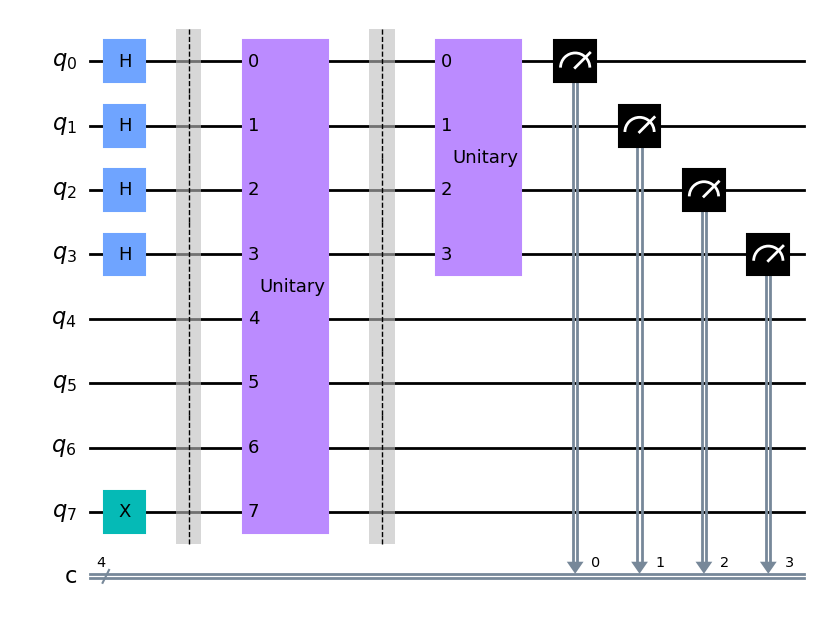

In [ ]:
qc = shor(n,m)
qc.draw('mpl')

# Quantum lab
**FA1**. Duotajai qiskit schemai sympy priemonėmis raskite atitinkamą unitarinę transformaciją, atitinkamus tikrinius vektorius ir jų fazes. Užduoties variantai yra [>>>>](https://docs.google.com/document/d/1-y3EHC3zBhIUw13b7MMBeZGdQTyiWKQlb_RhP2Ez4n8/edit?usp=sharing)
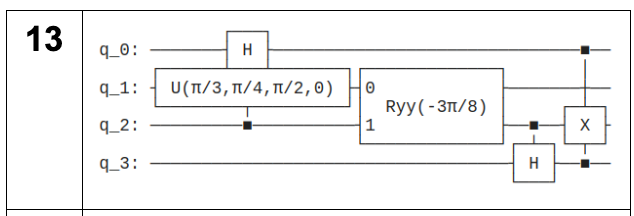

**FA2**. Sukurkite trijų kubitų  schemą, kurioje turi būti X, CX, H vartai. Jos  unitarinei matricai atlikite fazės aproksimacijos algoritmą qiskit aplinkoje. Palyginkite rastą $\theta$ reikšmę su tiksliąją (kurią Jūs galite rasti panašiai kaip FA1 užduotyje).

 **O1.** Duotiesiems $N$ ir $a$ raskite operatoriaus $M_a$ matricą (žr. daugiau [>>>>](https://learning.quantum-computing.ibm.com/course/fundamentals-of-quantum-algorithms/phase-estimation-and-factoring#order-finding))

Variantai:
1. $N=27, a=10$

In [2]:
import numpy as np
from sympy import Array
from math import gcd

N = 27
a = 10

array = np.zeros((N,N))
for i in range(N):
    array[a*i%N][i] = 1

Array(array)

[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

**ShA**. Panagrinėkite Šoro algoritmo implementaciją [>>>>](https://https://learning.quantum-computing.ibm.com/course/fundamentals-of-quantum-algorithms/phase-estimation-and-factoring#implementation-in-qiskit). Funkciją c_amod15(a) pakeiskite analogiška funkcija pagal Jūsų  variantą ir atlikite korekcijas kitose funkcijose taip, kad galima būtų išskaidyti duotąjį $N$:


1. $N=187$;


In [7]:
basisGates = ['cx','swap','x','u', 'id','ccx','cccx','cswap']
backend = Aer.get_backend('qasm_simulator')

def getGate(N,a):
    qubits = math.ceil(math.log(N,2))
    letters = []
    for i in range(qubits):
        letter = chr(ord('a') + i)
        letters.append(letter)

    modulus = []
    for i in range(2**qubits):
        if i < N:
            modulus.append((i,(a*i)%N))
        else:
            modulus.append((i,i))

    truthValues = []
    for index in range(qubits):
        tempTruthValues = []
        for i in range(2**qubits):
            _, value = modulus[i]
            tempTruthValues.append(bin(value)[2:].rjust(qubits, '0')[index])
        truthValues.append(tempTruthValues)

    allANFs = []
    print (truthValues)
    for i in range(len(truthValues)):
        truthValuesI =[ int(j) for j in truthValues[i]]
        anfForm = ANFform(letters, truthValuesI).__str__()
        print(anfForm)
        anf = anfForm.split(" ^ ")
        for i in range(len(anf)):
            anf[i]= anf[i].replace("(", "").replace(")", "")
            anf[i] = anf[i].split(" & ")
            for j in range(len(anf[i])):
                if anf[i][j] != "True":
                    for k in range(len(letters)):
                        anf[i][j] = anf[i][j].replace(letters[k], str(k))
                    anf[i][j] = int(anf[i][j])
        allANFs.append(anf)

    qc = QuantumCircuit(2*qubits)
    ind = qubits

    for i in range(len(allANFs)):
        for j in range(len(allANFs[i])):
            if allANFs[i][j][0] == 'True':
                qc.x(ind)
            else:
                qc.mcx(allANFs[i][j], ind)
        ind+=1
    qc.swap(range(qubits), range(qubits,2*qubits))
    
    return qc.to_gate()


def getCoprimeListWithEvenPeriod(N):
    aList = []
    for i in range(N-1):
        if gcd(i,N) == 1 and i != 1:
            remainder = 0
            count = 1
            while remainder != 1:
                if remainder == 0:
                    remainder = (i)%N
                remainder = (remainder*i)%N
                count += 1
            if count%2 == 0:
                if gcd(i**(count//2)-1,N) != 1 and gcd(i**(count//2)+1,N) != 1:
                    aList.append(i)
    return aList

def generateAModMatrix(a,N):
    qc = QuantumCircuit(math.ceil(math.log(N,2)))
    qubits = math.ceil(math.log(N,2))
    matrix = np.zeros((2**qubits, 2**qubits))
    for i in range(0,2**qubits):
        if i < N:
            matrix[a*i%N][i] = 1
        else:
            matrix[i][i] = 1
    qc.unitary(matrix, range(qubits))
    return Operator(qc)

def aMod15(x,gat,size):
    qc = QuantumCircuit(size)
    for _ in range(x):
        qc.append(gat, range(size-1,-1,-1))
    unitary = qc.to_gate()
    return unitary.control(1)

# def modExp(n,N,m,a):
#     qc = QuantumCircuit(n+m,name='modExp')
#     gate = generateAModMatrix(a,N)
#     gate = transpile(gate, basis_gates=basisGates, optimization_level=3,seed_transpiler=11)
#     print(n)
#     for i in range(n):
#         aaa = aMod15(2**i,gate, m)
#         transpiled = transpile(aaa, basis_gates=basisGates, optimization_level=3,seed_transpiler=11)
#         qc.append(transpiled,[i]+list(range(n,m+n)))
#         print("appended")
#     return Operator(qc)

def prepareCircuits(n,N,a):
    transpiledCircuits = []
    gate = generateAModMatrix(a,N)
    # specGate = getGate(N,a)
    # get qubits
    # print(specGate.num_qubits)
    # specGate = specGate.control(1)

    
    for i in range(n):
        print(i+1, "th circuit out of ", n)
        qubits = math.ceil(math.log(N,2))
        # qc = QuantumCircuit(qubits*3)# was *2
        # testing
        # for _ in range(2**i):
        #     qc.append(specGate, [i] + list(range(qubits,qubits*3)))
        # qc.reset(range(qubits*2, qubits*3))
        qc = QuantumCircuit(qubits*2)
        qc.append(aMod15(1,gate,qubits), [i]+list(range(qubits,qubits*2)))
        # transpiled = transpile(qc, backend= backend, basis_gates=basisGates, optimization_level=3,seed_transpiler=11)
        # transpiledCircuits.append(transpiled)
        transpiledCircuits.append(qc)
    return transpiledCircuits

def shor(n:int, N:int, m:int, a:int=2):
    # qc = QuantumCircuit(n+m+m, n)   
    qc = QuantumCircuit(n+m, n)   
    
    qc.h(range(n))
    qc.x(n+m-1)
    qc.barrier()
    print(n)
    transpiledCircuits = prepareCircuits(n,N,a)
    for i in range(n):
        x = 2**i
        
        # for _ in range(x):
        # qc.append(transpiledCircuits[i],range(n+m+m))
        qc.append(transpiledCircuits[i],range(n+m))
    qc.barrier()
    qc.append(Operator(QFT(n).inverse()).to_instruction(), range(n))
    qc.measure(range(n), range(n))
    return qc

def processMeasurement(measurement,n):
    binaryString = ''.join(map(str, measurement))
    measuredInt = int(binaryString,2)
    phase = measuredInt/(2**n)
    f = Fraction.from_float(phase).limit_denominator(n)
    _,r = f.numerator, f.denominator
    print ("corresponding phase",phase," r ",r)
    return r, phase

In [11]:
# N = 55 # number to factor
N = 187
n=math.ceil(math.log(N,2))
m=math.ceil(math.log(N,2))
coprimeListWithEvenPeriods = getCoprimeListWithEvenPeriod(N)
print (coprimeListWithEvenPeriods)
if len(coprimeListWithEvenPeriods) == 0:
    raise Exception('No coprime list with even periods found')
coprime = False
while coprime == False:
    a = np.random.randint(2, N)
    if a in coprimeListWithEvenPeriods:
        coprime = True

factorFound = False
attempts = 0
print ("trying with a=",a,"and N=",N)
qc = shor(n,N,m,a)
print("shor constructed")
# t_gate = transpile(qc, backend, basis_gates=basisGates, seed_transpiler=11)
qcc = qc.decompose(reps=2)
print("transpiled")
while factorFound == False:
    attempts += 1
    # job = backend.run(t_gate, shots=1)
    job = backend.run(qcc, shots=1)
    result = job.result()
    counts = list(result.get_counts().keys())
    print ("attempts",attempts,"counts",counts)
    r, phase = processMeasurement(counts[0],n)
    if phase != 0 and r%2 == 0:
        guesses = [math.gcd(a**(r//2)-1,N), math.gcd(a**(r//2)+1,N)]
        print ("guesses",guesses)
        for guess in guesses:
            if guess not in [1,N] and N%guess == 0:
                factorFound = True
                print ("Found non trivial factors of",N,"; ",guess,"and",N//guess)
                break

[2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 35, 36, 37, 38, 39, 40, 41, 42, 43, 45, 46, 47, 48, 49, 52, 53, 54, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 67, 70, 71, 72, 73, 74, 75, 76, 78, 79, 80, 81, 82, 83, 87, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 100, 104, 105, 106, 107, 108, 109, 111, 112, 113, 114, 115, 116, 117, 120, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 133, 134, 135, 138, 139, 140, 141, 142, 144, 145, 146, 147, 148, 149, 150, 151, 152, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 166, 167, 168, 169, 171, 172, 173, 174, 175, 177, 178, 179, 180, 181, 182, 183, 184, 185]
trying with a= 7 and N= 187
8
1 th circuit out of  8
2 th circuit out of  8
3 th circuit out of  8
4 th circuit out of  8
5 th circuit out of  8
6 th circuit out of  8
7 th circuit out of  8
8 th circuit out of  8
shor constructed
transpiled
attempts 1 counts ['11111000']
corresponding phase 0.96875  r  1
attempts 2 counts ['00000000']

KeyboardInterrupt: 

/Users/pijus/.pyenv/versions/3.11.4/lib/python3.11/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


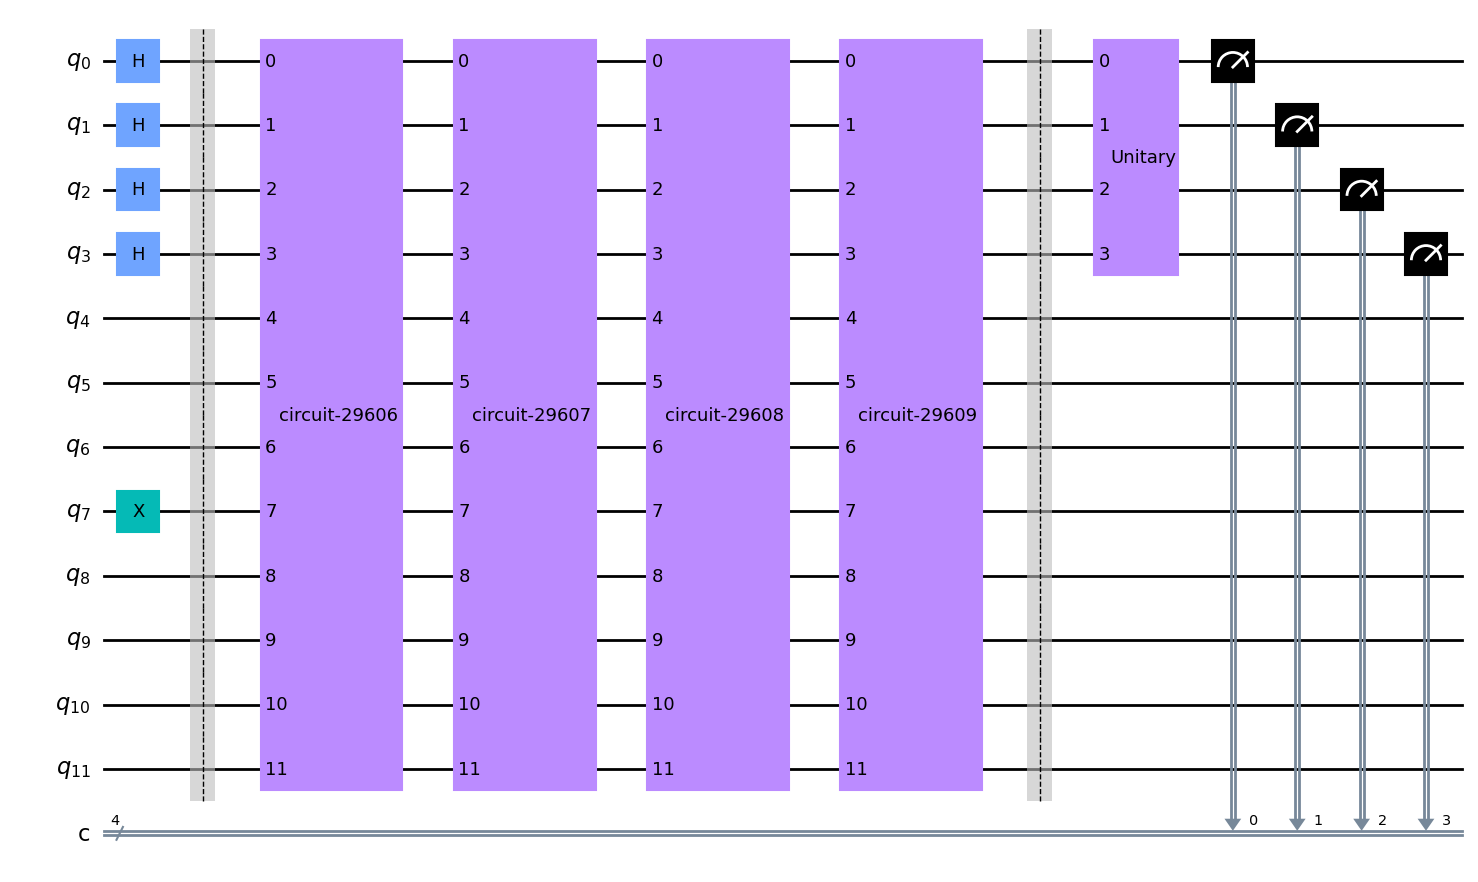

In [186]:
qc.draw('mpl')

In [76]:
from qiskit import QuantumCircuit, execute, Aer
from qiskit.quantum_info.operators import Operator
import numpy as np
from typing import List
import galois
from sympy import *
from sympy.physics.quantum import *
from sympy.physics.quantum.qubit import *
import math
from sympy.logic.boolalg import Boolean

Boolean.__rxor__ = Boolean.__xor__

[['0', '0', '0', '0', '1', '1', '1', '1', '0', '0', '0', '0', '1', '1', '1', '1'], ['0', '0', '1', '1', '0', '0', '1', '1', '0', '0', '1', '1', '0', '0', '1', '1'], ['0', '1', '0', '1', '0', '1', '0', '1', '0', '1', '0', '1', '0', '1', '0', '1'], ['0', '0', '0', '0', '0', '0', '0', '0', '1', '1', '1', '1', '1', '1', '1', '1']]
b
c
d
a


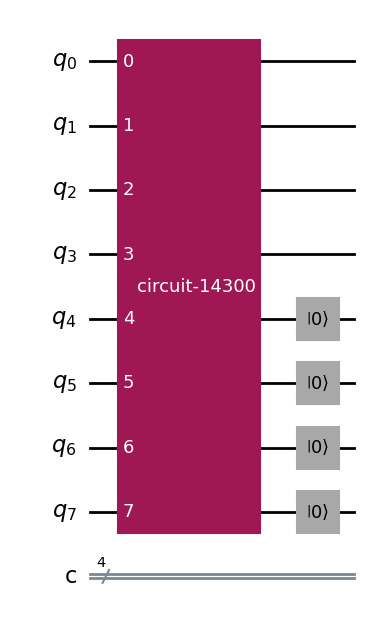

In [165]:
N = 15
c = 8
a = 2


qubits = 4
qc = QuantumCircuit(8,4)
qc.append(getGate(N,a), range(8))
qc.reset(range(qubits,2*qubits))


# backend = Aer.get_backend('qasm_simulator')
# job = backend.run(qc, shots=1024)
# result = job.result()
# print(result.get_counts())
# counts = list(result.get_counts().keys())[0]
# print (int(counts[::-1],2))  


qc.draw('mpl',style='iqx')


# return qc.to_gate()
# qc = QuantumCircuit(qubits)

# for i in range(len(allANFs)-1):
#     anf = allANFs[i]
#     for j in range(len(anf)):
#         if anf[j] != [i]:
#             print (anf[j], i)
#             qc.mct(anf[j], i)
# qc.draw('mpl')